In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Cargar datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')

# 1. Preparar variables de inversión
inv_columns = [
    'MMM05_INV_CINE', 'MMM05_INV_EXTERIOR', 'MMM05_INV_INTERNET',
    'MMM05_INV_PRENSA', 'MMM05_INV_PRODUCCION', 'MMM05_INV_RADIO',
    'MMM05_INV_REVISTAS', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_VARIOS'
]

df_inv_pct = df[inv_columns].div(df['MMM05_INV_INV_Total'], axis=0)
df_inv_lag = df_inv_pct.shift(1).dropna()

# 2. Preparar variable objetivo
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']
y = df['Ratio_Ventas_Trafico'].dropna()

# 3. Construir matriz de características CORREGIDO
easter = df['MMM04_TIME_Easterweek'].rename('Semana_Santa')
black_friday = pd.Series((df.index.month == 11).astype(int), 
                        index=df.index, 
                        name='Black_Friday')
weekends = pd.Series(df['MMM04_TIME_Dias_fines_semana']/df['MMM04_TIME_Dias_mes'], 
                    index=df.index, 
                    name='Fin_de_Semana')

X = df_inv_lag.join([easter, black_friday, weekends]).dropna()
y = y.reindex(X.index)

# 4. Entrenar modelo Ridge
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = Ridge(alpha=1.0).fit(X_scaled, y)

# 5. Obtener coeficientes de inversión
coef_df = pd.DataFrame({
    'Canal': inv_columns,
    'Coeficiente': model.coef_[:len(inv_columns)]
}).sort_values('Coeficiente', ascending=False)

# 6. Aplicar restricciones mínimas
MIN_CINE = 0.05
MIN_PLATAFORMAS_OTROS = 0.15

# Forzar mínimos
coef_df['Coeficiente_ajustado'] = np.where(
    coef_df['Canal'] == 'MMM05_INV_CINE',
    np.maximum(coef_df['Coeficiente'], MIN_CINE),
    np.where(
        coef_df['Canal'].isin(['MMM05_INV_PlataformasVideo', 'MMM05_INV_VARIOS']),
        np.maximum(coef_df['Coeficiente'], MIN_PLATAFORMAS_OTROS),
        coef_df['Coeficiente']
    )
)

# Normalizar para que sumen 1
coef_df['Distribucion_optima'] = coef_df['Coeficiente_ajustado'] / coef_df['Coeficiente_ajustado'].sum()

print("\nDistribución óptima de inversión con restricciones:")
print(coef_df[['Canal', 'Distribucion_optima']])

# 7. Calcular presupuestos para cada periodo
presupuesto_base = df['MMM05_INV_INV_Total'].mean()  # Presupuesto promedio 2024

escenarios = {
    'Primeros 6 meses': 1.15,
    'Siguientes 6 meses': 1.21,
    'Año siguiente': 1.25
}

for escenario, multiplicador in escenarios.items():
    presupuesto = presupuesto_base * multiplicador
    print(f"\n{escenario} - Presupuesto total: {presupuesto:,.2f}")
    print((coef_df['Distribucion_optima'] * presupuesto).to_string())


Distribución óptima de inversión con restricciones:
                        Canal  Distribucion_optima
4        MMM05_INV_PRODUCCION             0.019237
3            MMM05_INV_PRENSA             0.015828
2          MMM05_INV_INTERNET             0.014184
5             MMM05_INV_RADIO             0.003096
7  MMM05_INV_PlataformasVideo             0.417476
1          MMM05_INV_EXTERIOR            -0.013204
6          MMM05_INV_REVISTAS            -0.013252
0              MMM05_INV_CINE             0.139159
8            MMM05_INV_VARIOS             0.417476

Primeros 6 meses - Presupuesto total: 662,983.70
4     12753.557057
3     10493.897480
2      9403.852344
5      2052.673926
7    276779.820802
1     -8754.026338
6     -8785.835871
0     92259.940267
8    276779.820802

Siguientes 6 meses - Presupuesto total: 697,574.15
4     13418.960033
3     11041.405175
2      9894.488118
5      2159.769957
7    291220.507105
1     -9210.758147
6     -9244.227308
0     97073.502368
8    291220.

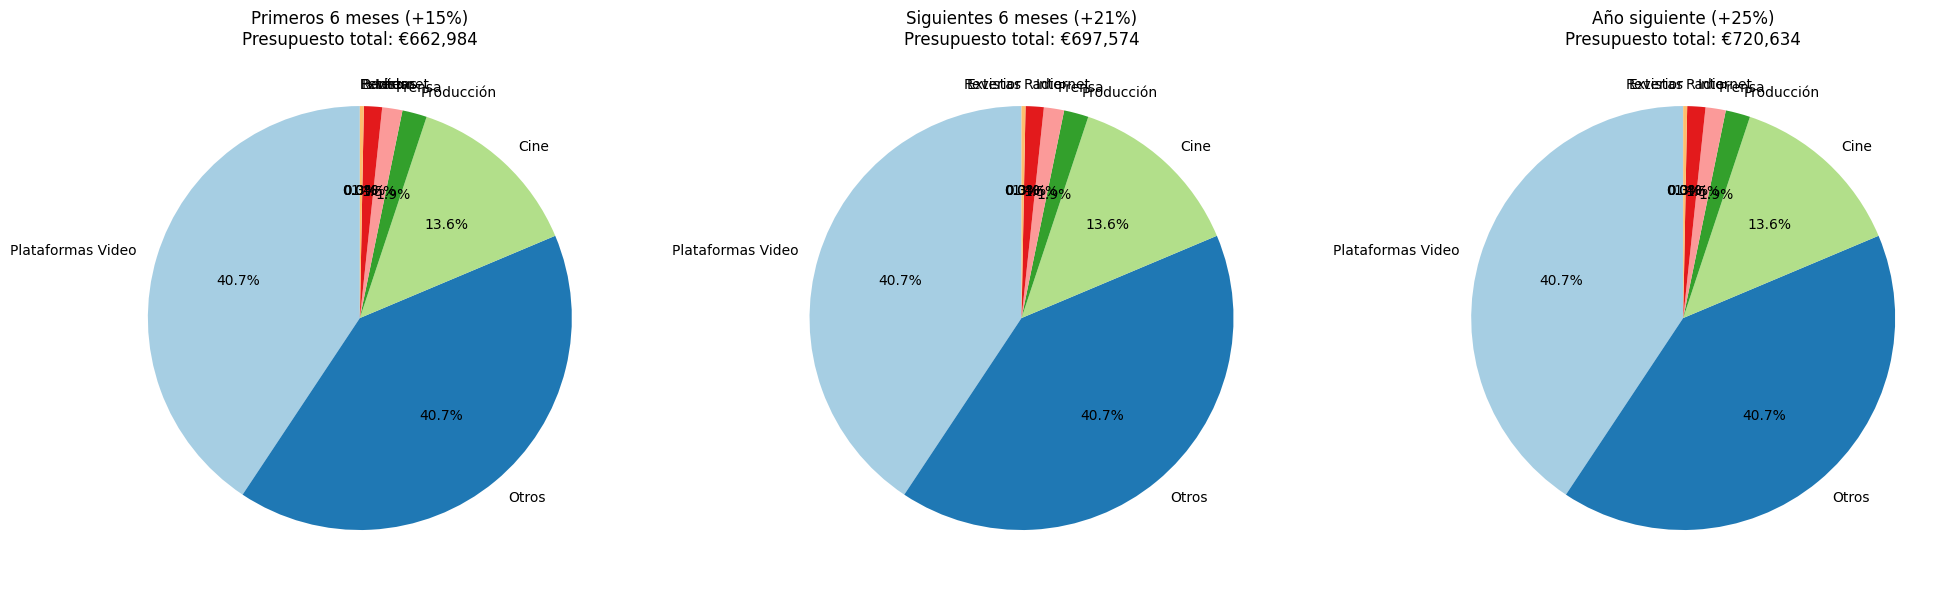


Distribución óptima de inversión (%):
|            |   Plataformas Video |   Otros |   Cine |   Producción |   Prensa |   Internet |   Radio |   Exterior |   Revistas |
|:-----------|--------------------:|--------:|-------:|-------------:|---------:|-----------:|--------:|-----------:|-----------:|
| Asignación |                40.7 |    40.7 |   13.6 |          1.9 |      1.5 |        1.4 |     0.3 |          0 |          0 |


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Cargar datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')

# 1. Preparar variables de inversión
canales = {
    'Cine': 'MMM05_INV_CINE',
    'Exterior': 'MMM05_INV_EXTERIOR',
    'Internet': 'MMM05_INV_INTERNET',
    'Prensa': 'MMM05_INV_PRENSA',
    'Producción': 'MMM05_INV_PRODUCCION',
    'Radio': 'MMM05_INV_RADIO',
    'Revistas': 'MMM05_INV_REVISTAS',
    'Plataformas_Video': 'MMM05_INV_PlataformasVideo',
    'Otros': 'MMM05_INV_VARIOS'
}

df_inv_pct = df[list(canales.values())].div(df['MMM05_INV_INV_Total'], axis=0)
df_inv_lag = df_inv_pct.shift(1).dropna()

# 2. Preparar variable objetivo
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']
y = df['Ratio_Ventas_Trafico'].dropna()

# 3. Construir matriz de características
easter = df['MMM04_TIME_Easterweek'].rename('Semana_Santa')
black_friday = pd.Series((df.index.month == 11).astype(int), 
                        index=df.index, 
                        name='Black_Friday')
weekends = pd.Series(df['MMM04_TIME_Dias_fines_semana']/df['MMM04_TIME_Dias_mes'], 
                    index=df.index, 
                    name='Fin_de_Semana')

X = df_inv_lag.join([easter, black_friday, weekends]).dropna()
y = y.reindex(X.index)

# 4. Entrenar modelo Ridge con coeficientes no negativos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Forzar no negatividad mediante ajuste post-modelo
model = Ridge(alpha=1.0).fit(X_scaled, y)
coeficientes = np.maximum(model.coef_[:len(canales)], 0)  # Forzar a mínimo 0

# 5. Aplicar restricciones mínimas
canales_restricciones = {
    'Cine': 0.05,
    'Plataformas_Video': 0.15,
    'Otros': 0.15
}

for canal, minimo in canales_restricciones.items():
    idx = list(canales.keys()).index(canal)
    coeficientes[idx] = np.maximum(coeficientes[idx], minimo)

# Normalizar para que sumen 1
coeficientes_norm = coeficientes / coeficientes.sum()

# Crear DataFrame con nombres legibles
distribucion = pd.DataFrame({
    'Canal': [n.replace('_', ' ') for n in canales.keys()],
    'Asignación': coeficientes_norm
}).sort_values('Asignación', ascending=False)

# 6. Calcular presupuestos y visualizar
presupuesto_base = df['MMM05_INV_INV_Total'].mean()
escenarios = {
    'Primeros 6 meses (+15%)': 1.15,
    'Siguientes 6 meses (+21%)': 1.21,
    'Año siguiente (+25%)': 1.25
}

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for ax, (nombre, mult) in zip(axs, escenarios.items()):
    presupuesto = presupuesto_base * mult
    asignacion = (distribucion['Asignación'] * presupuesto).round(2)
    
    # Crear gráfico de pastel
    ax.pie(asignacion, 
           labels=distribucion['Canal'],
           autopct='%1.1f%%',
           startangle=90,
           colors=plt.cm.Paired.colors)
    ax.set_title(f"{nombre}\nPresupuesto total: €{presupuesto:,.0f}")

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("\nDistribución óptima de inversión (%):")
print((distribucion.set_index('Canal')*100).round(1).T.to_markdown())

In [7]:
# 6. Generar tabla comparativa de los tres escenarios
escenarios = {
    'Primeros 6 meses (+15%)': 1.15,
    'Siguientes 6 meses (+21%)': 1.21,
    'Año siguiente (+25%)': 1.25
}

# Crear DataFrame con todos los escenarios
resultados = []
for nombre, mult in escenarios.items():
    presupuesto = presupuesto_base * mult
    asignacion = (distribucion['Asignación'] * presupuesto).round(2)
    resultados.append(pd.Series(asignacion.values, 
                              index=distribucion['Canal'], 
                              name=nombre))

df_resultados = pd.concat(resultados, axis=1)

# Formatear tabla para presentación
def format_currency(x):
    return f"€{x:,.2f}" if x >= 0 else f"(€{abs(x):,.2f})"

df_show = df_resultados.copy()
df_show['Distribución Base (%)'] = (distribucion['Asignación']*100).round(1)

print("\nTabla comparativa de asignación por escenario:")
print(df_show.applymap(format_currency).to_markdown())


Tabla comparativa de asignación por escenario:
| Canal             | Primeros 6 meses (+15%)   | Siguientes 6 meses (+21%)   | Año siguiente (+25%)   | Distribución Base (%)   |
|:------------------|:--------------------------|:----------------------------|:-----------------------|:------------------------|
| Plataformas Video | €269,646.08               | €283,714.57                 | €293,093.56            | (€nan)                  |
| Otros             | €269,646.08               | €283,714.57                 | €293,093.56            | (€nan)                  |
| Cine              | €89,882.03                | €94,571.52                  | €97,697.85             | (€nan)                  |
| Producción        | €12,424.85                | €13,073.10                  | €13,505.27             | (€nan)                  |
| Prensa            | €10,223.43                | €10,756.82                  | €11,112.42             | (€nan)                  |
| Internet          | €9,161.48    

C:\Users\aleja\AppData\Local\Temp\ipykernel_1900\2766748694.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df_show.applymap(format_currency).to_markdown())


Validación previa al gráfico:
               Grupo  Asignación
1  Plataformas_Video    0.428571
2              Otros    0.428571
0               Cine    0.142857
3           Internet    0.000000


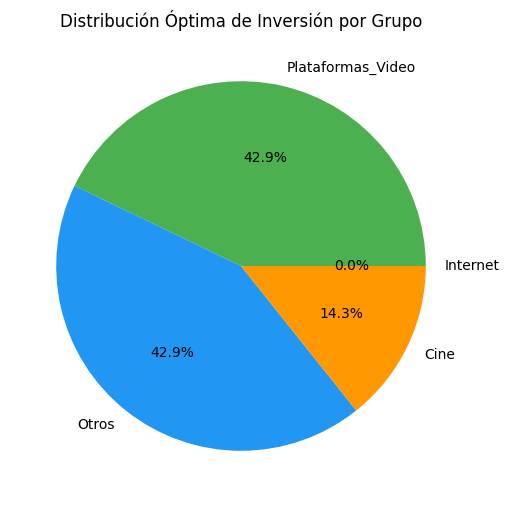

In [12]:
# ========== PASO 1: Preparación de variables adicionales ==========
# Añadir variables web y temporales faltantes
df['Ratio_Ventas_Trafico_Lag1'] = df['Ratio_Ventas_Trafico'].shift(1)
navidad = pd.Series(((df.index.month == 12) & (df.index.day >= 15)).astype(int),
                    index=df.index, 
                    name='Navidad')

# Variables web con lag
web_vars = [
    'MMM01_WEB_PaidSearch', 
    'MMM01_WEB_SocialNetworks',
    'MMM01_WEB_NaturalSearch', 
    'MMM01_WEB_Unique_visitors'
]
df_web_lag = df[web_vars].shift(1)

# ========== PASO 2: Actualizar matriz de diseño ==========
X = df_inv_lag.join([
    easter,
    black_friday,
    navidad,
    weekends,
    df_web_lag,
    df['Ratio_Ventas_Trafico_Lag1']
]).dropna()

# ========== PASO 3: Entrenar modelo actualizado ==========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = Ridge(alpha=1.0).fit(X_scaled, y)

# ========== PASO 4: Agrupación de canales ==========
# Mapeo de coeficientes a grupos
grupos = {
    'Internet': ['MMM05_INV_INTERNET'],
    'Plataformas_Video': ['MMM05_INV_PlataformasVideo'],
    'Cine': ['MMM05_INV_CINE'],
    'Otros': [
        'MMM05_INV_EXTERIOR', 
        'MMM05_INV_PRENSA',
        'MMM05_INV_PRODUCCION', 
        'MMM05_INV_RADIO',
        'MMM05_INV_REVISTAS', 
        'MMM05_INV_VARIOS'
    ]
}

# Extraer coeficientes de inversión
coef_inversion = pd.Series(
    model.coef_[:len(canales)], 
    index=list(canales.values())
)

# Agrupar coeficientes
coef_agrupados = {}
for grupo, canales_grupo in grupos.items():
    coef_agrupados[grupo] = coef_inversion[canales_grupo].sum()

# ========== PASO 5 CORREGIDO: Aplicar restricciones ==========
coef_ajustados = pd.Series({
    'Cine': max(coef_agrupados['Cine'], 0.05),
    'Plataformas_Video': max(coef_agrupados['Plataformas_Video'], 0.15),
    'Otros': max(coef_agrupados['Otros'], 0.15),
    'Internet': max(coef_agrupados['Internet'], 0)  # Forzar no negatividad
})

# Verificar y corregir valores negativos
coef_ajustados = np.maximum(coef_ajustados, 0)  # Asegurar todos ≥ 0

# Normalizar
coef_final = coef_ajustados / coef_ajustados.sum()

# ========== PASO 6 CORREGIDO: Visualización ==========
distribucion_final = pd.DataFrame({
    'Grupo': coef_final.index,
    'Asignación': coef_final.values
}).sort_values('Asignación', ascending=False)

# Validar datos antes de graficar
print("Validación previa al gráfico:")
print(distribucion_final)

# Gráfico de pastel seguro
fig, ax = plt.subplots(figsize=(10, 6))
if (distribucion_final['Asignación'] >= 0).all():
    ax.pie(distribucion_final['Asignación'],
           labels=distribucion_final['Grupo'],
           autopct='%1.1f%%',
           colors=['#4CAF50', '#2196F3', '#FF9800', '#9E9E9E'])
    ax.set_title("Distribución Óptima de Inversión por Grupo")
else:
    print("Error: Valores negativos detectados en la distribución")

plt.show()